<h1> Summary </h1>
This dataset (ml-20m) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 20000263 ratings and 465564 tag applications across 27278 movies. These data were created by 138493 users between January 09, 1995 and March 31, 2015. This dataset was generated on October 17, 2016.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in six files, genome-scores.csv, genome-tags.csv, links.csv, movies.csv, ratings.csv and tags.csv. More details about the contents and use of all these files follows.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

<h1> Formatting and Encoding </h1>
The dataset files are written as comma-separated values files with a single header row. Columns that contain commas (,) are escaped using double-quotes ("). These files are encoded as UTF-8. If accented characters in movie titles or tag values (e.g. Misérables, Les (1995)) display incorrectly, make sure that any program reading the data, such as a text editor, terminal, or script, is configured for UTF-8.

<h2> User Ids </h2>
MovieLens users were selected at random for inclusion. Their ids have been anonymized. User ids are consistent between ratings.csv and tags.csv (i.e., the same id refers to the same user across the two files).

<h2> Movie Ids </h2>
Only movies with at least one rating or tag are included in the dataset. These movie ids are consistent with those used on the MovieLens web site (e.g., id 1 corresponds to the URL https://movielens.org/movies/1). Movie ids are consistent between ratings.csv, tags.csv, movies.csv, and links.csv (i.e., the same id refers to the same movie across these four data files).

Ratings Data File Structure (ratings.csv)
All ratings are contained in the file ratings.csv. Each line of this file after the header row represents one rating of one movie by one user, and has the following format:

userId,movieId,rating,timestamp
The lines within this file are ordered first by userId, then, within user, by movieId.

Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

Tags Data File Structure (tags.csv)
All tags are contained in the file tags.csv. Each line of this file after the header row represents one tag applied to one movie by one user, and has the following format:

userId,movieId,tag,timestamp
The lines within this file are ordered first by userId, then, within user, by movieId.

Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user.

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

Movies Data File Structure (movies.csv)
Movie information is contained in the file movies.csv. Each line of this file after the header row represents one movie, and has the following format:

movieId,title,genres
Movie titles are entered manually or imported from https://www.themoviedb.org/, and include the year of release in parentheses. Errors and inconsistencies may exist in these titles.

Genres are a pipe-separated list, and are selected from the following:

Action
Adventure
Animation
Children's
Comedy
Crime
Documentary
Drama
Fantasy
Film-Noir
Horror
Musical
Mystery
Romance
Sci-Fi
Thriller
War
Western
(no genres listed)
Links Data File Structure (links.csv)
Identifiers that can be used to link to other sources of movie data are contained in the file links.csv. Each line of this file after the header row represents one movie, and has the following format:

movieId,imdbId,tmdbId
movieId is an identifier for movies used by https://movielens.org. E.g., the movie Toy Story has the link https://movielens.org/movies/1.

imdbId is an identifier for movies used by http://www.imdb.com. E.g., the movie Toy Story has the link http://www.imdb.com/title/tt0114709/.

tmdbId is an identifier for movies used by https://www.themoviedb.org. E.g., the movie Toy Story has the link https://www.themoviedb.org/movie/862.

Use of the resources listed above is subject to the terms of each provider.

Tag Genome (genome-scores.csv and genome-tags.csv)
This data set includes a current copy of the Tag Genome.

The tag genome is a data structure that contains tag relevance scores for movies. The structure is a dense matrix: each movie in the genome has a value for every tag in the genome.

As described in this article, the tag genome encodes how strongly movies exhibit particular properties represented by tags (atmospheric, thought-provoking, realistic, etc.). The tag genome was computed using a machine learning algorithm on user-contributed content including tags, ratings, and textual reviews.

The genome is split into two files. The file genome-scores.csv contains movie-tag relevance data in the following format:

movieId,tagId,relevance
The second file, genome-tags.csv, provides the tag descriptions for the tag IDs in the genome file, in the following format:

tagId,tag
The tagId values are generated when the data set is exported, so they may vary from version to version of the MovieLens data sets.

Cross-Validation
Prior versions of the MovieLens dataset included either pre-computed cross-folds or scripts to perform this computation. We no longer bundle either of these features with the dataset, since most modern toolkits provide this as a built-in feature. If you wish to learn about standard approaches to cross-fold computation in the context of recommender systems evaluation, see LensKit for tools, documentation, and open-source code examples.

In [3]:
# Setting up some parameters for the workbook
import matplotlib

pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = None

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (25,5)

In [4]:
from scipy import sparse

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import xgboost as xgb

from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SlopeOne
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

In [5]:
from datetime import datetime
import os
import random
import gc

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [8]:
# Loading the dataset

movie_ratings = pd.read_csv(r'/Users/briangor/Downloads/ratings.csv')


In [9]:
movie_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [11]:
movies = pd.read_csv(r'/Users/briangor/Downloads/movies.csv')

In [12]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [15]:
movies.duplicated().sum() #checking for duplicates

0

In [17]:
movie_ratings.duplicated().sum()

0

In [19]:
movies.shape

(27278, 3)

In [21]:
movie_ratings.shape

(20000263, 4)

In [22]:
# Converting the UTC timestamp to Datetime
movie_ratings["timestamp"] = movie_ratings["timestamp"].apply(lambda x: datetime.utcfromtimestamp(x).strftime("%Y-%m-%d"))

In [23]:
# Merging the movies and ratings data files
movie_ratings = movie_ratings.merge(movies, how="left", on="movieId")

In [27]:
movie_ratings.tail()

,userId,movieId,rating,timestamp,title,genres
20000258,138493,68954,4.5,2009-11-13,Up (2009),Adventure|Animation|Children|Drama
20000259,138493,69526,4.5,2009-12-03,Transformers: Revenge of the Fallen (2009),Action|Adventure|Sci-Fi|IMAX
20000260,138493,69644,3.0,2009-12-07,Ice Age: Dawn of the Dinosaurs (2009),Action|Adventure|Animation|Children|Comedy|Rom...
20000261,138493,70286,5.0,2009-11-13,District 9 (2009),Mystery|Sci-Fi|Thriller
20000262,138493,71619,2.5,2009-10-17,Coco Before Chanel (Coco avant Chanel) (2009),Drama


In [28]:
movie_ratings.shape

(20000263, 6)

In [29]:
movie_ratings.duplicated().sum()

0

In [30]:
# Renaming the timestamp to date
movie_ratings.rename(columns={"timestamp": "date"}, inplace=True)

In [32]:
movie_ratings.columns

Index(['userId', 'movieId', 'rating', 'date', 'title', 'genres'], dtype='object')

In [33]:
# Sorting ratings based on date
movie_ratings.sort_values(by = "date", inplace = True)
movie_ratings.reset_index(drop=True, inplace=True)

In [34]:
# Checking the features and no. of records in the dataset

print("The number of records are : ", movie_ratings.shape[0])
print("The number of features are : ", movie_ratings.shape[1])
print("The list of features is : ", movie_ratings.columns)
movie_ratings.head()

The number of records are :  20000263
The number of features are :  6
The list of features is :  Index(['userId', 'movieId', 'rating', 'date', 'title', 'genres'], dtype='object')


,userId,movieId,rating,date,title,genres
0,131160,1079,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,28507,1176,4.0,1995-01-09,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
3,131160,21,3.0,1995-01-09,Get Shorty (1995),Comedy|Crime|Thriller
4,85252,7,5.0,1996-01-29,Sabrina (1995),Comedy|Romance


In [35]:
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
 3   date     object 
 4   title    object 
 5   genres   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 915.5+ MB


In [36]:
movie_ratings.describe()

,userId,movieId,rating
count,2.000026e+07,2.000026e+07,2.000026e+07
mean,6.904587e+04,9.041567e+03,3.525529e+00
std,4.003863e+04,1.978948e+04,1.051989e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,3.439500e+04,9.020000e+02,3.000000e+00
50%,6.914100e+04,2.167000e+03,3.500000e+00
75%,1.036370e+05,4.770000e+03,4.000000e+00
max,1.384930e+05,1.312620e+05,5.000000e+00


In [37]:
movie_ratings.isna().sum()

userId     0
movieId    0
rating     0
date       0
title      0
genres     0
dtype: int64

In [40]:
# Checking the feature "userID"

total_users = len(np.unique(movie_ratings["userId"]))
print("The count of unique userID in the dataset is : ", total_users)
print("The top 5 userID in the dataset are : \n", movie_ratings["userId"].value_counts()[:5])

The count of unique userID in the dataset is :  138493
The top 5 userID in the dataset are : 
 118205    9254
8405      7515
82418     5646
121535    5520
125794    5491
Name: userId, dtype: int64


In [41]:
#Checking the feature "movieID"
total_movies = len(np.unique(movie_ratings["movieId"]))
print("The count of unique movieID in the dataset is : ", total_movies)
print("The top 5 movieID in the dataset are : \n", movie_ratings["movieId"].value_counts()[:5])

The count of unique movieID in the dataset is :  26744
The top 5 movieID in the dataset are : 
 296    67310
356    66172
318    63366
593    63299
480    59715
Name: movieId, dtype: int64


In [42]:
# Helper function to Change the numeric label in terms of Millions
def changingLabels(number):

    return str(number/10**6) + "M"

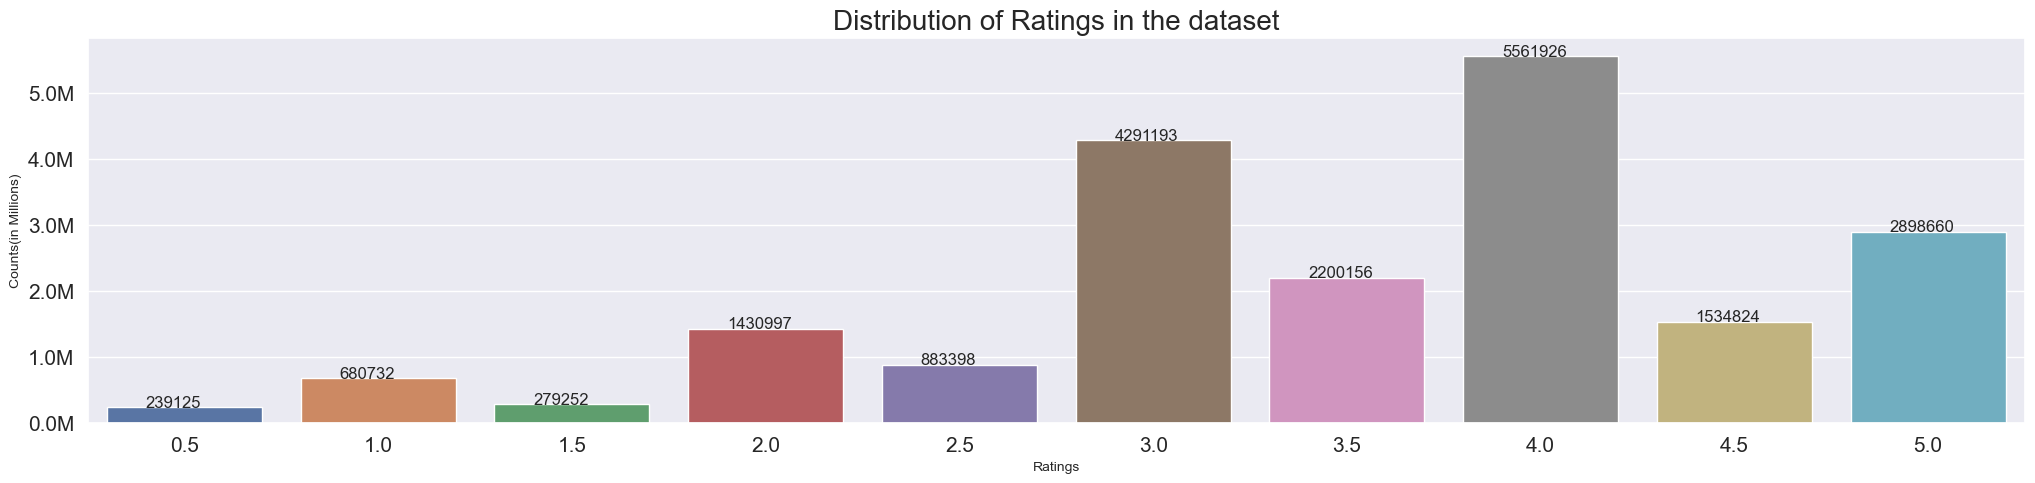

In [43]:
# Checking the feature "rating"
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.countplot("rating", data=movie_ratings, ax=axes)
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
for p in axes.patches:
    axes.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+100))

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in the dataset", fontsize = 20)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Counts(in Millions)", fontsize = 10)
plt.show()

In [44]:
# Checking the feature "date"
print("The count of unique date in the dataset is : ", movie_ratings["date"].nunique())
print("The first rating was given on : ", movie_ratings["date"].min())
print("The latest rating was given on : ", movie_ratings["date"].max())
print("The top 5 date in the dataset are : \n", movie_ratings["date"].value_counts()[:5])

The count of unique date in the dataset is :  6911
The first rating was given on :  1995-01-09
The latest rating was given on :  2015-03-31
The top 5 date in the dataset are : 
 2000-11-20    91753
2005-03-22    76568
1999-12-11    65077
2008-10-29    55163
2000-11-21    54131
Name: date, dtype: int64


In [45]:
# Checking the feature "title"
movie_list = movie_ratings["title"].unique()
print("The count of unique title in the dataset is : ", movie_ratings["title"].nunique())
print("The top 5 title in the dataset are : \n", movie_ratings["title"].value_counts()[:5])

The count of unique title in the dataset is :  26729
The top 5 title in the dataset are : 
 Pulp Fiction (1994)                 67310
Forrest Gump (1994)                 66172
Shawshank Redemption, The (1994)    63366
Silence of the Lambs, The (1991)    63299
Jurassic Park (1993)                59715
Name: title, dtype: int64


In [48]:
#Extract unique Genres along with their count

unique_genres = {}

def ExtractGenres(x):
    for g in x.split("|"):
        if g not in unique_genres.keys():
            unique_genres[g] = 1
        else:
            unique_genres[g] = unique_genres[g] + 1

movie_ratings["genres"].apply(ExtractGenres)
print("Genres Extracted from the dataset.")

Genres Extracted from the dataset.


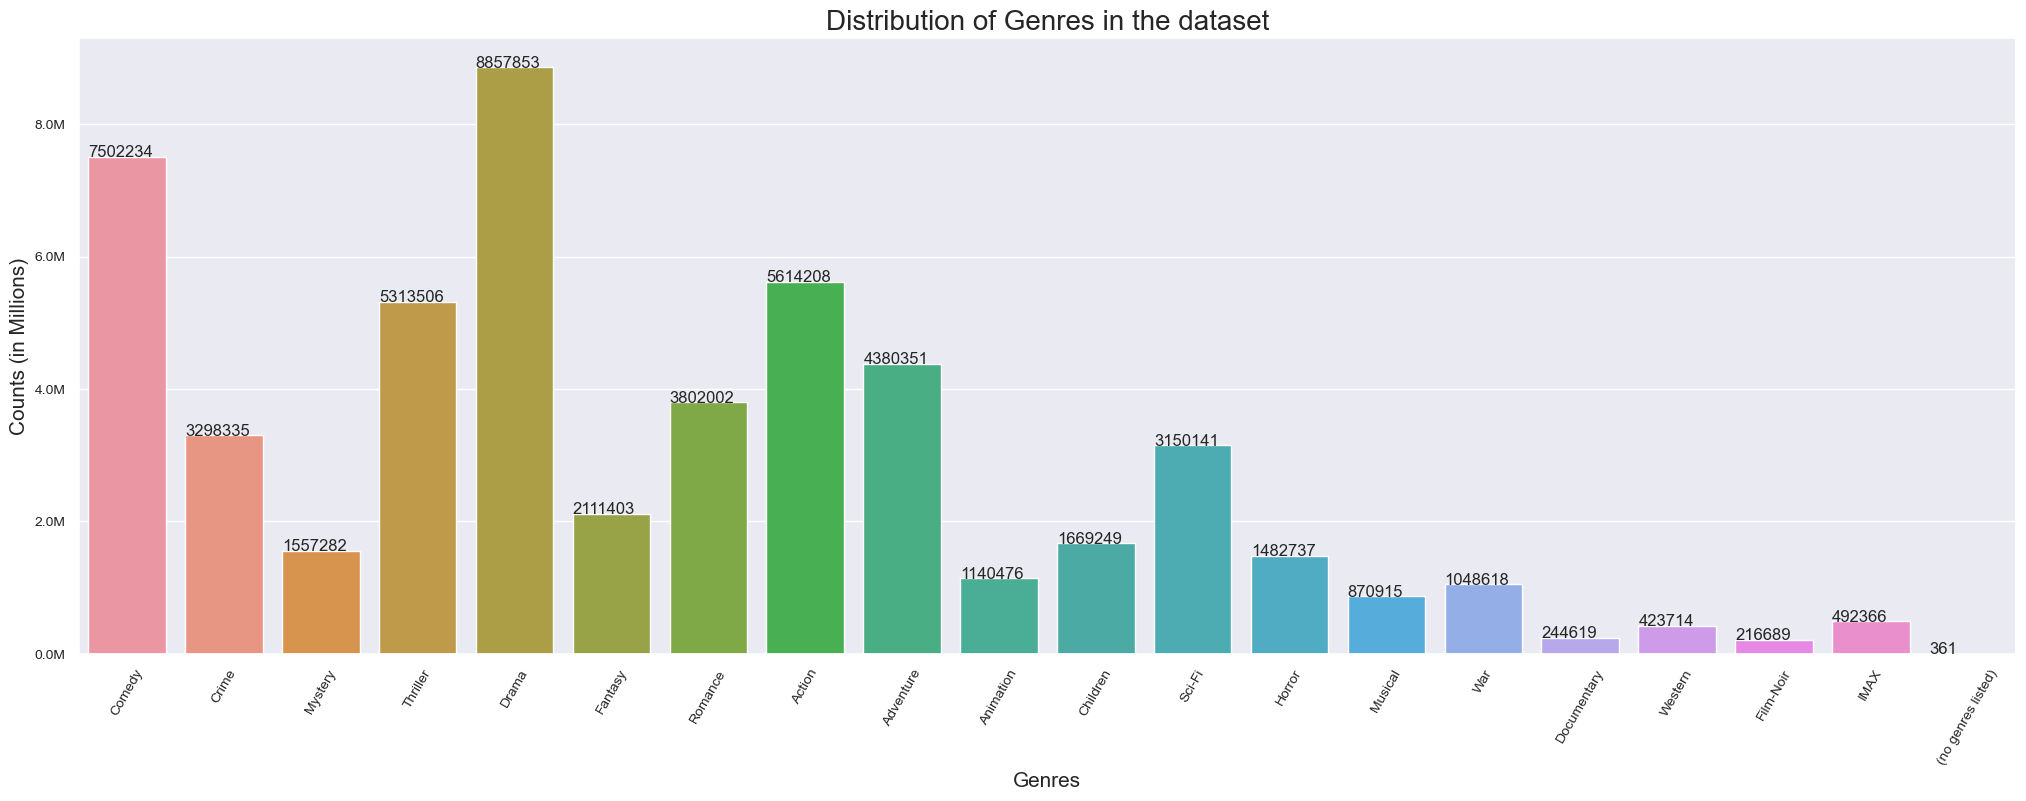

In [49]:
#Visualizing the feature "Genres"

genres_df = pd.DataFrame(list(unique_genres.items()))
genres_df.columns = ["Genre", "Count"] 

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 8), sharey=True)

sns.barplot(y="Count", x="Genre", data=genres_df, ax=axes)
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

plt.tick_params(labelsize = 15)
plt.title("Distribution of Genres in the dataset", fontsize = 20)
plt.xlabel("Genres", fontsize = 15)
plt.xticks(rotation=60, fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts (in Millions)", fontsize = 15)
plt.show()
     

In [50]:
genres_df

,Genre,Count
0,Comedy,7502234
1,Crime,3298335
2,Mystery,1557282
3,Thriller,5313506
4,Drama,8857853
5,Fantasy,2111403
6,Romance,3802002
7,Action,5614208
8,Adventure,4380351
9,Animation,1140476


In [51]:
# Creating the train test set

file_path = r"/Users/briangor/Downloads/"

if not os.path.isfile(file_path + "/TrainData.pkl"):
    print("Creating Train Data and saving it..")
    movie_ratings.iloc[:int(movie_ratings.shape[0] * 0.80)].to_pickle(file_path + "/TrainData.pkl")
    Train_Data = pd.read_pickle(file_path + "/TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)
else:
    print("Loading Train Data..")
    Train_Data = pd.read_pickle(file_path + "/TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)

if not os.path.isfile(file_path + "/TestData.pkl"):
    print("Creating Test Data and saving it..")
    movie_ratings.iloc[int(movie_ratings.shape[0] * 0.80):].to_pickle(file_path + "/TestData.pkl")
    Test_Data = pd.read_pickle(file_path + "/TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)
else:
    print("Loading Test Data..")
    Test_Data = pd.read_pickle(file_path + "/TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)

Creating Train Data and saving it..
Creating Test Data and saving it..


In [52]:
Train_Data.head()

,userId,movieId,rating,date,title,genres
0,131160,1079,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,28507,1176,4.0,1995-01-09,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
3,131160,21,3.0,1995-01-09,Get Shorty (1995),Comedy|Crime|Thriller
4,85252,7,5.0,1996-01-29,Sabrina (1995),Comedy|Romance


In [53]:
# Creating list of unique movies from Train Set
movie_list_in_training = Train_Data.drop_duplicates(subset=["title"], keep="first")[["movieId", "title", "genres"]]
movie_list_in_training = movie_list_in_training.reset_index(drop=True)
movie_list_in_training.head()

,movieId,title,genres
0,1079,"Fish Called Wanda, A (1988)",Comedy|Crime
1,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,1176,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
3,21,Get Shorty (1995),Comedy|Crime|Thriller
4,7,Sabrina (1995),Comedy|Romance


In [54]:
# Extracting the day of week from the date when rating was provided
Train_Data["date"] = pd.to_datetime(Train_Data["date"], errors='coerce')
Train_Data["DayOfWeek"] = Train_Data["date"].dt.strftime('%A')
Train_Data["Weekday"] = Train_Data["date"].apply(lambda x : 1 if x.dayofweek > 5 else 0)
     

In [55]:
# Converting the number into 'Ks.

def ChangingLabelsInK(number):
    return str(int(number/10**3)) + "K"

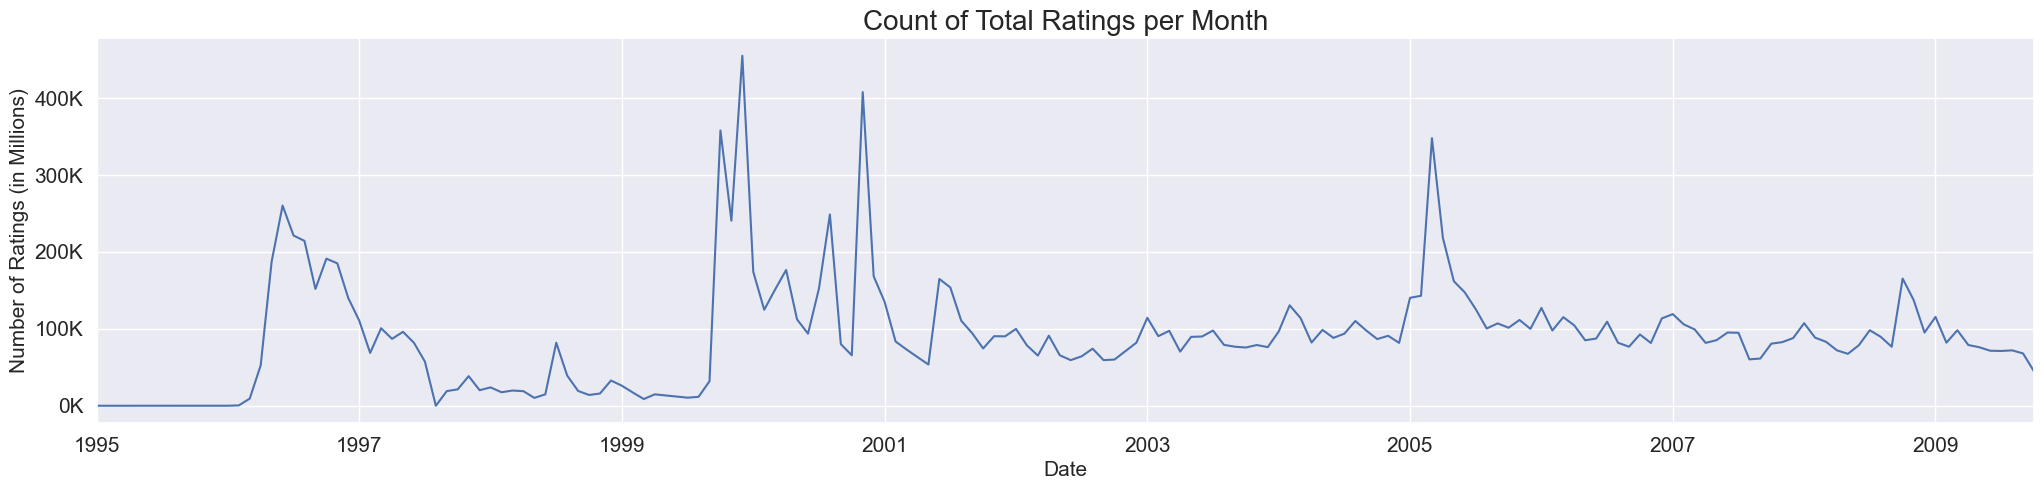

In [56]:
# Visualizing the count of total ratings made per month

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)
axes = Train_Data.resample("m", on = "date")["rating"].count().plot()

axes.set_yticklabels([ChangingLabelsInK(num) for num in axes.get_yticks()])
axes.set_title("Count of Total Ratings per Month", fontsize = 20)
axes.set_xlabel("Date", fontsize = 15)
axes.set_ylabel("Number of Ratings (in Millions)", fontsize = 15)
plt.tick_params(labelsize = 15)
plt.show()

<h1> Feature Engineering </h1>

In [58]:
# Path for loading/saving files
file_path = r"/Users/briangor/Downloads/"

In [59]:
# Creating/loading user-movie sparse matrix for train data

startTime = datetime.now()

print("Creating USER_ITEM sparse matrix for train Data..")

if os.path.isfile(file_path + "/TrainUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TrainUISparseData = sparse.load_npz(file_path + "/TrainUISparseData.npz")
    print("Shape of Train Sparse matrix = "+str(TrainUISparseData.shape))    
else:
    print("We are creating sparse data..")
    TrainUISparseData = sparse.csr_matrix((Train_Data.rating, (Train_Data.userId, Train_Data.movieId)))
    print("Creation done. Shape of sparse matrix : ", str(TrainUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz(file_path + "/TrainUISparseData.npz", TrainUISparseData)
    print("Done\n")

print("Time taken : ", datetime.now() - startTime)

Creating USER_ITEM sparse matrix for train Data..
We are creating sparse data..
Creation done. Shape of sparse matrix :  (138494, 71766)
Saving it into disk for furthur usage.
Done

Time taken :  0:00:37.248171


In [60]:
rows,cols = TrainUISparseData.shape
presentElements = TrainUISparseData.count_nonzero()

print("Sparsity Of Train matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Train matrix : 99.8390184950274% 


In [61]:
# Creating/loading user-movie sparse matrix for test data

startTime = datetime.now()

print("Creating USER_ITEM sparse matrix for test Data..")

if os.path.isfile(file_path + "/TestUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TestUISparseData = sparse.load_npz(file_path + "/TestUISparseData.npz")
    print("Shape of Test Sparse Matrix : ", str(TestUISparseData.shape))
else:
    print("We are creating sparse data..")
    TestUISparseData = sparse.csr_matrix((Test_Data.rating, (Test_Data.userId, Test_Data.movieId)))
    print("Creation done. Shape of sparse matrix : ", str(TestUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz(file_path + "/TestUISparseData.npz", TestUISparseData)
    print("Done\n")

print("Time Taken : ", datetime.now() - startTime)

Creating USER_ITEM sparse matrix for test Data..
We are creating sparse data..
Creation done. Shape of sparse matrix :  (138494, 131263)
Saving it into disk for furthur usage.
Done

Time Taken :  0:00:04.199095


In [62]:
rows,cols = TestUISparseData.shape
presentElements = TestUISparseData.count_nonzero()

print("Sparsity Of Test matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Test matrix : 99.97799646486449% 


Observations:

Shape of sparse matrix depends on highest value of userId and highest value of movieId.
In the test set, there are few users from train set which is not present in the test set.
For the movieId, there are less movies in the train set as compared to test set. The reason stems from the fact that we split the data based on time, and newer movies would have fallen into test set.
The sparsity of train set is 99.19% while the sparsity of test set is 99.89%.

In [63]:
# Function to Calculate Average rating for users or movies from User-movie sparse matrix
 
def getAverageRatings(sparseMatrix, if_user):

    #axis = 1 means rows and axis = 0 means columns 
    ax = 1 if if_user else 0

    sumOfRatings = sparseMatrix.sum(axis = ax).A1  
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1  
    rows, cols = sparseMatrix.shape
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}
    
    return averageRatings

In [64]:
AvgRatingUser = getAverageRatings(TrainUISparseData, True)
AvgRatingMovie = getAverageRatings(TrainUISparseData, False)
train_users = len(AvgRatingUser)
uncommonUsers = total_users - train_users
                  
print("Total no. of Users : ", total_users)
print("No. of Users in Train data : ", train_users)
print("No. of Users not present in Train data : {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))
     

Total no. of Users :  138493
No. of Users in Train data :  112466
No. of Users not present in Train data : 26027(19.0%)


In [65]:
train_movies = len(AvgRatingMovie)
uncommonMovies = total_movies - train_movies
                  
print("Total no. of Movies : ", total_movies)
print("No. of Movies in Train data : ", train_movies)
print("No. of Movies not present in Train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total no. of Movies :  26744
No. of Movies in Train data :  12387
No. of Movies not present in Train data = 14357(54.0%)


bservations:

Recommendation System suffers from Cold Start problems, which needs to be tackled wisely in order to design a effective system.
There are 26027, ie 19% of the users are not present in the training data.
There are 12387, ie 54% of the movies which are not present in the training data.

<h2> Creating Similarity Matrix </h2>
Computation of user-user or item-item similarity matrix is impossible if computational power is limited given we have a user vector of size 112K. There will be a matrix of size 14K x 14K.

On the other hand, if we try to reduce the dimension say by truncated SVD then it would take even more time because truncated SVD creates dense matrix and amount of multiplication for creation of user-user similarity matrix would increase dramatically.

For the workaround, we will maintain a binary Vector for users, which tells us whether we already computed similarity for this user or not or compute top (let's just say, 1000) most similar users for this given user, and add this to our datastructure, so that we can just access it(similar users) without recomputing it again.

If it is already computed, just get it directly from our datastructure, which has that information. In production time, We might have to recompute similarities, if it is computed a long time ago. Because user preferences changes over time. If we could maintain some kind of Timer, which when expires, we have to update it ( recompute it ).

The datastructure to be used is purely implementation dependant.One simple method is to maintain a Dictionary Of Dictionaries:

key : userid
value : Again a dictionary
key : _Similar User
value: Similarity Value>

In [66]:
# Computing user-user similarity matrix for the train data
# We have 138K sized sparse vectors using which a 14K x 14K movie similarity matrix would be calculated

start = datetime.now()

if not os.path.isfile(file_path + "/m_m_similarity.npz"):
    print("Movie-Movie Similarity file does not exist in your disk. Creating Movie-Movie Similarity Matrix...")
    m_m_similarity = cosine_similarity(TrainUISparseData.T, dense_output = False)
    print("Dimension of Matrix : ", m_m_similarity.shape)
    print("Storing the Movie Similarity matrix on disk for further usage")
    sparse.save_npz(file_path + "/m_m_similarity.npz", m_m_similarity)
else:
    print("File exists in the disk. Loading the file...")
    m_m_similarity = sparse.load_npz(file_path + "/m_m_similarity.npz")
    print("Dimension of Matrix : ", m_m_similarity.shape)
    
print("The time taken to compute movie-movie similarity matrix is : ", datetime.now() - start)

Movie-Movie Similarity file does not exist in your disk. Creating Movie-Movie Similarity Matrix...
Dimension of Matrix :  (71766, 71766)
Storing the Movie Similarity matrix on disk for further usage
The time taken to compute movie-movie similarity matrix is :  0:03:48.500585


In [67]:
# Creating a function to take Movie Name and generate the top matched name and generate its N similar movies based on M-M Similary

def GetSimilarMoviesUsingMovieMovieSimilarity(movie_name, num_of_similar_movies):
    matches = process.extract(movie_name, movie_list_in_training["title"], scorer=fuzz.partial_ratio)
    if len(matches) == 0:
        return "No Match Found"
    movie_id = movie_list_in_training.iloc[matches[0][2]]["movieId"]
    similar_movie_id_list = np.argsort(-m_m_similarity[movie_id].toarray().ravel())[0:num_of_similar_movies+1]
    sm_df = movie_list_in_training[movie_list_in_training["movieId"].isin(similar_movie_id_list)]
    sm_df["order"] = sm_df.apply(lambda x: list(similar_movie_id_list).index(x["movieId"]), axis=1)
    
    return sm_df.sort_values("order")

In [68]:
# Picking random movie and checking it's top 10 most similar movies

GetSimilarMoviesUsingMovieMovieSimilarity("Superman", 10)

,movieId,title,genres,order
2526,2641,Superman II (1980),Action|Sci-Fi,0
2530,2642,Superman III (1983),Action|Adventure|Sci-Fi,1
2527,2640,Superman (1978),Action|Adventure|Sci-Fi,2
2531,2643,Superman IV: The Quest for Peace (1987),Action|Adventure|Sci-Fi,3
2877,2985,RoboCop (1987),Action|Crime|Drama|Sci-Fi|Thriller,4
1340,1375,Star Trek III: The Search for Spock (1984),Action|Adventure|Sci-Fi,5
2012,2105,Tron (1982),Action|Adventure|Sci-Fi,6
1339,1374,Star Trek II: The Wrath of Khan (1982),Action|Adventure|Sci-Fi|Thriller,7
1341,1376,Star Trek IV: The Voyage Home (1986),Adventure|Comedy|Sci-Fi,8
2807,2916,Total Recall (1990),Action|Adventure|Sci-Fi|Thriller,9


<h3> 2.2. Computing User-User Similarity Matrix. </h3>

In [69]:
#Getting highest user id

row_index, col_index = TrainUISparseData.nonzero()
unique_user_id = np.unique(row_index)
print("Max User id is :", np.max(unique_user_id))

Max User id is : 138493


Time elapsed for 20 users = 0:00:13.128574sec
Time elapsed for 40 users = 0:00:24.799071sec
Time elapsed for 60 users = 0:00:42.213000sec
Time elapsed for 80 users = 0:00:53.202004sec
Time elapsed for 100 users = 0:01:04.002468sec
Average Time taken to compute similarity matrix for 1 user = 0.6208711886405944seconds


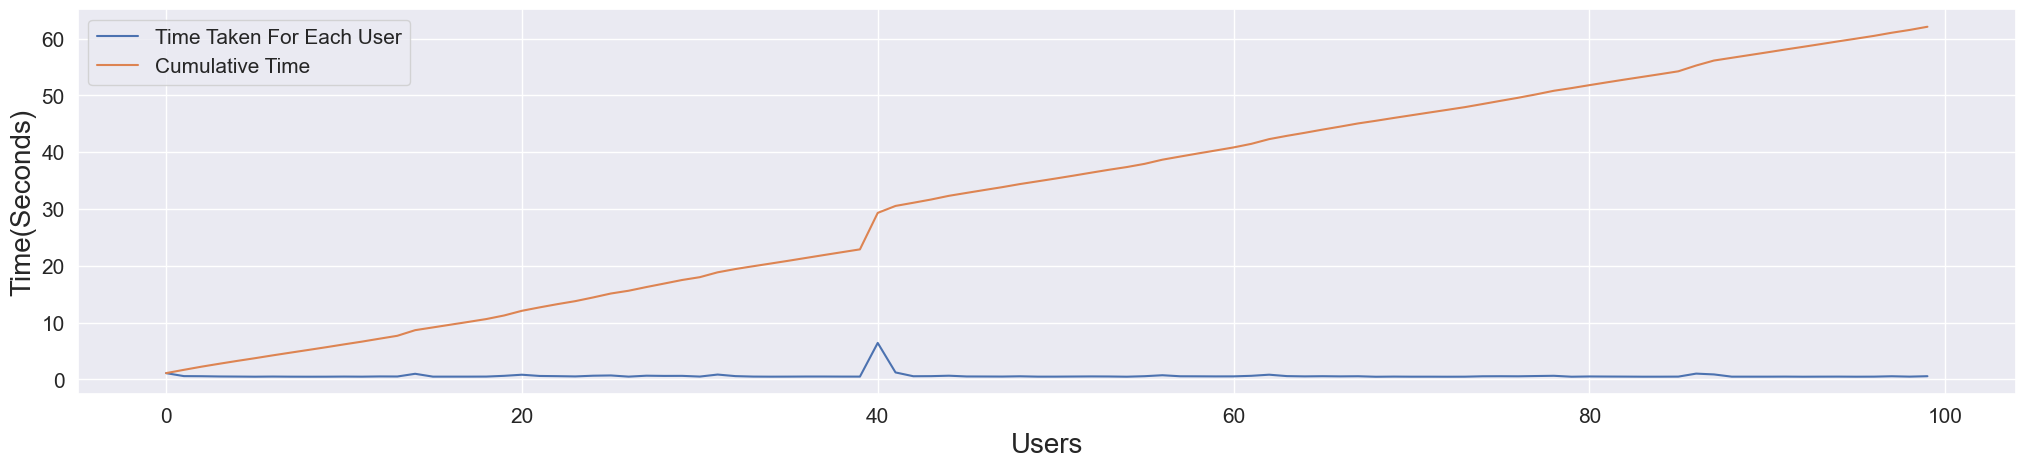

In [70]:
# Here, we are calculating user-user similarity matrix only for first 100 users in our sparse matrix. And we are calculating 
# Top 100 most similar users with them.

def getUser_UserSimilarity(sparseMatrix, top = 100):
    startTimestamp20 = datetime.now()  
    
    row_index, col_index = sparseMatrix.nonzero()
    rows = np.unique(row_index)
    similarMatrix = np.zeros(13849300).reshape(138493,100)    # 138493*100 = 13849300. As we are building similarity matrix only 
    #for top 100 most similar users.
    timeTaken = []
    howManyDone = 0
    for row in rows[:top]:
        howManyDone += 1
        startTimestamp = datetime.now().timestamp()  #it will give seconds elapsed
        sim = cosine_similarity(sparseMatrix.getrow(row), sparseMatrix).ravel()
        top100_similar_indices = sim.argsort()[-top:]
        top100_similar = sim[top100_similar_indices]
        similarMatrix[row] = top100_similar
        timeforOne = datetime.now().timestamp() - startTimestamp
        timeTaken.append(timeforOne)
        if howManyDone % 20 == 0:
            print("Time elapsed for {} users = {}sec".format(howManyDone, (datetime.now() - startTimestamp20)))
    print("Average Time taken to compute similarity matrix for 1 user = "+str(sum(timeTaken)/len(timeTaken))+"seconds")

    sns.set(style="darkgrid")
    fig = plt.figure(figsize = (25, 5))
    plt.plot(timeTaken, label = 'Time Taken For Each User')
    plt.plot(np.cumsum(timeTaken), label='Cumulative Time')
    plt.legend(loc='upper left', fontsize = 15)
    plt.xlabel('Users', fontsize = 20)
    plt.ylabel('Time(Seconds)', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()
    
    return similarMatrix

simMatrix = getUser_UserSimilarity(TrainUISparseData, 100)

In [71]:
# Calculating user-user similarity only for particular users in our sparse matrix and return user_ids

def Calculate_User_User_Similarity(sparseMatrix, user_id, num_of_similar_users=10):
    
    if user_id in unique_user_id:
        # Calculating the cosine similarity for user_id with all the "userId"
        sim = cosine_similarity(sparseMatrix.getrow(user_id), sparseMatrix).ravel()
        # Sorting the indexs(user_id) based on the similarity score for all the user ids
        top_similar_user_ids = sim.argsort()[::-1]
        # Sorted the similarity values
        top_similarity_values = sim[top_similar_user_ids]

    return top_similar_user_ids[1: num_of_similar_users+1]

In [72]:
# Getting top 5 users similar to userId: 1

similar_users_1 = Calculate_User_User_Similarity(TrainUISparseData, 1, 5)
similar_users_1

array([81275, 62235,  2595, 75328, 34101])

<h3> 3.3.2 Feature Extraction </h3>


In [73]:
# Path for saving/loading files
file_path = r"/Users/briangor/Downloads/"

In [76]:
# Since the given dataset might not completely fit into computaton capacity that we have,
# we will sample the data and work it

# Function for Sampling random movies and users to reduce the size of rating matrix
def get_sample_sparse_matrix(sparseMatrix, n_users, n_movies, matrix_name):

    np.random.seed(15)   #this will give same random number everytime, without replacement
    startTime = datetime.now()

    users, movies, ratings = sparse.find(sparseMatrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)

    userS = np.random.choice(uniq_users, n_users, replace = False)
    movieS = np.random.choice(uniq_movies, n_movies, replace = False)
    mask = np.logical_and(np.isin(users, userS), np.isin(movies, movieS))
    sparse_sample = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), shape = (max(userS)+1, max(movieS)+1))
 
    print("Sparse Matrix creation done. Saving it for later use.")
    sparse.save_npz(file_path + "/" + matrix_name, sparse_sample)
    print("Shape of Sparse Sampled Matrix = " + str(sparse_sample.shape))    
    print("Time taken : ", datetime.now() - startTime)

    return sparse_sample

In [77]:
# Creating Sample Sparse Matrix for Train Data

if not os.path.isfile(file_path + "/TrainUISparseData_Sample.npz"):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    train_sample_sparse = get_sample_sparse_matrix(TrainUISparseData, 5000, 1000, "TrainUISparseData_Sample.npz")
else:
    print("File is already present in the disk. Loading the file...")
    train_sample_sparse = sparse.load_npz(file_path + "/TrainUISparseData_Sample.npz")
    print("Shape of Train Sample Sparse Matrix = " + str(train_sample_sparse.shape))

Sample sparse matrix is not present in the disk. We are creating it...
Sparse Matrix creation done. Saving it for later use.
Shape of Sparse Sampled Matrix = (138488, 71701)
Time taken :  0:00:15.188456


In [78]:
# Creating Sample Sparse Matrix for Test Data

if not os.path.isfile(file_path + "/TestUISparseData_Sample.npz"):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    test_sample_sparse = get_sample_sparse_matrix(TestUISparseData, 2000, 200, "TestUISparseData_Sample.npz")
else:
    print("File is already present in the disk. Loading the file...")
    test_sample_sparse = sparse.load_npz(file_path + "/TestUISparseData_Sample.npz")
    print("Shape of Test Sample Sparse Matrix = " + str(test_sample_sparse.shape))
     

Sample sparse matrix is not present in the disk. We are creating it...
Sparse Matrix creation done. Saving it for later use.
Shape of Sparse Sampled Matrix = (138456, 131022)
Time taken :  0:00:03.627786


In [79]:
# Checking the shape of Training and test data

print("Shape of Train Sparse Matrix : ", train_sample_sparse.shape)
print("Shape of Test Sparse Matrix : ", test_sample_sparse.shape)

Shape of Train Sparse Matrix :  (138488, 71701)
Shape of Test Sparse Matrix :  (138456, 131022)


In [80]:
# Calculating few GlobalAverageRating, AvgMovieRating, AvgUserRating and TotalNoOfRatings

globalAvgRating = np.round((train_sample_sparse.sum()/train_sample_sparse.count_nonzero()), 2)
globalAvgMovies = getAverageRatings(train_sample_sparse, False)
globalAvgUsers = getAverageRatings(train_sample_sparse, True)
print("Global average of all movies ratings in Train Set is : ", globalAvgRating)
print("No. of ratings in the train matrix is : ", train_sample_sparse.count_nonzero())

Global average of all movies ratings in Train Set is :  3.5
No. of ratings in the train matrix is :  54216


In [81]:
# Function to extract features and create row using the sparse matrix

def CreateFeaturesForTrainData(SampledSparseData, TrainSampledSparseData):

    startTime = datetime.now()

    # Extracting userId list, movieId list and Ratings
    sample_users, sample_movies, sample_ratings = sparse.find(SampledSparseData)
    
    print("No. of rows in the returned dataset : ", len(sample_ratings))
    
    count = 0
    data = []
    
    for user, movie, rating in zip(sample_users, sample_movies, sample_ratings):

        row = list()

#----------------------------------Appending "user Id" average, "movie Id" average & global average rating-----------#
        row.append(user)  
        row.append(movie) 
        row.append(globalAvgRating) 

#----------------------------------Appending "user" average, "movie" average & rating of "user""movie"-----------#
        try:
            row.append(globalAvgUsers[user])
        except (KeyError):
            global_average_rating = globalAvgRating
            row.append(global_average_rating)
        except:
            raise
        try:            
            row.append(globalAvgMovies[movie])
        except (KeyError):
            global_average_rating = globalAvgRating
            row.append(global_average_rating)
        except:
            raise

#----------------------------------Ratings given to "movie" by top 5 similar users with "user"--------------------#
        try:
            similar_users = cosine_similarity(TrainSampledSparseData[user], TrainSampledSparseData).ravel()
            similar_users_indices = np.argsort(-similar_users)[1:]
            similar_users_ratings = TrainSampledSparseData[similar_users_indices, movie].toarray().ravel()
            top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
            top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "movie" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "movie" average rating.
            row.extend(top_similar_user_ratings)
        #########Cold Start Problem, for a new user or a new movie######### 
        except (IndexError, KeyError):
            global_average_rating = [globalAvgRating]*5
            row.extend(global_average_rating)
        except:
            raise

#----------------------------------Ratings given by "user" to top 5 similar movies with "movie"------------------#
        try:
            similar_movies = cosine_similarity(TrainSampledSparseData[:,movie].T, TrainSampledSparseData.T).ravel()
            similar_movies_indices = np.argsort(-similar_movies)[1:]
            similar_movies_ratings = TrainSampledSparseData[user, similar_movies_indices].toarray().ravel()
            top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
            top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
            row.extend(top_similar_movie_ratings)
        ########Cold Start Problem, for a new user or a new movie#########
        except (IndexError, KeyError):
            global_average_rating = [globalAvgRating] * 5
            row.extend(global_average_rating)
        except:
            raise
              
#----------------------------------Appending rating of "user""movie"-----------#
        row.append(rating)

        count += 1
        
        data.append(row)
        
        if count % 5000 == 0:
            print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))

    print("Total Time for {} rows = {}".format(len(data), (datetime.now() - startTime)))
    print("Completed..")
    return data
     

In [82]:
# Using sampled train data, creating Features for each row and saving it into the list

data_rows = CreateFeaturesForTrainData(train_sample_sparse, train_sample_sparse)

No. of rows in the returned dataset :  54216
Done for 5000. Time elapsed: 0:02:39.865228
Done for 10000. Time elapsed: 0:04:54.441656
Done for 15000. Time elapsed: 0:07:06.116509
Done for 20000. Time elapsed: 0:09:20.779093
Done for 25000. Time elapsed: 0:11:31.931670
Done for 30000. Time elapsed: 0:13:44.237743
Done for 35000. Time elapsed: 0:15:54.019021
Done for 40000. Time elapsed: 0:18:04.475789
Done for 45000. Time elapsed: 0:20:29.094760
Done for 50000. Time elapsed: 0:22:57.561682
Total Time for 54216 rows = 0:24:51.036788
Completed..


In [83]:
# Using sampled train data, creating Features for each row and saving it into the list

test_data_rows = CreateFeaturesForTrainData(test_sample_sparse, train_sample_sparse)

No. of rows in the returned dataset :  2084
Total Time for 2084 rows = 0:00:42.422573
Completed..


In [84]:
# Creating the pandas dataframe from the data rows extracted from the sparse matrix for train and test set

names = ["User_ID", "Movie_ID", "Global_Average", "User_Average", "Movie_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "Rating"]
train_regression_data = pd.DataFrame(data_rows, columns=names)
test_regression_data = pd.DataFrame(test_data_rows, columns=names)

In [85]:
# Saving the df to drive for future use

train_regression_data.to_csv(file_path + "/Training_Data_For_Regression.csv")
test_regression_data.to_csv(file_path + "/Testing_Data_For_Regression.csv")

In [88]:
# Loading the train and test csv files

# Path for saving/loading files
file_path = r"/Users/briangor/Downloads/"

print("File is already present in the disk. Loading the file...")

train_regression_data = pd.read_csv(file_path + "/Training_Data_For_Regression.csv")
train_regression_data = train_regression_data.drop(["Unnamed: 0"], axis=1)

test_regression_data = pd.read_csv(file_path + "/Testing_Data_For_Regression.csv")
test_regression_data = test_regression_data.drop(["Unnamed: 0"], axis=1)

print("Done..")

File is already present in the disk. Loading the file...
Done..


In [89]:
# Checking the shape and first few records for train data

print("The shape of the dataframe is : ", train_regression_data.shape)
print("Number of missing Values : ", train_regression_data.isnull().sum().sum())
train_regression_data.head()

The shape of the dataframe is :  (54216, 16)
Number of missing Values :  0


,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating
0,332,25,3.5,3.142857,3.70987,4.0,5.0,3.0,3.0,5.0,5.0,3.0,2.0,3.0,2.0,5.0
1,463,25,3.5,3.875000,3.70987,5.0,5.0,4.0,4.0,5.0,4.0,4.0,4.0,3.0,4.0,5.0
2,484,25,3.5,5.000000,3.70987,5.0,5.0,3.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
3,592,25,3.5,5.000000,3.70987,5.0,4.0,5.0,3.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0
4,640,25,3.5,3.166667,3.70987,3.0,3.0,5.0,4.0,5.0,3.0,5.0,3.0,3.0,3.0,2.0


In [90]:
# Checking the shape and first few records for test data

print("The shape of the dataframe is : ", test_regression_data.shape)
print("Number of missing Values : ", test_regression_data.isnull().sum().sum())
test_regression_data.head()

The shape of the dataframe is :  (2084, 16)
Number of missing Values :  0


,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating
0,24024,78,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.0
1,89299,78,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.0
2,89495,78,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.0
3,105227,78,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.0
4,500,610,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.0


Observations:

The description of the features are stated below:

User_ID: ID of a this User
Movie_ID: ID of a this Movie
Global_Average: Global Average Rating
User_Average: Average Rating of this User
Movie_Average: Average Rating of this Movie
Ratings given to this Movie by top 5 similar users with this User: (SUR1, SUR2, SUR3, SUR4, SUR5)
Ratings given by this User to top 5 similar movies with this Movie: (SMR1, SMR2, SMR3, SMR4, SMR5)
Rating: Rating given by this User to this Movie

Transforming Data for Surprise Models

Transforming Train Data:

We can't give raw data (movie, user, rating) to train the model in Surprise library. They have a separate format for TRAIN and TEST data, which will be useful for training the models like SVD, KNN, BaseLineOnly, etc.., in Surprise.

We can form the trainset from a file, or from a Pandas DataFrame. http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py

Transforming Test Data:

For test data we just have to define a tuple (user, item, rating). Check out this link: https://github.com/NicolasHug/Surprise/commit/86cf44529ca0bbb97759b81d1716ff547b950812

Above link is a github of surprise library. Check methods "def all_ratings(self)" and "def build_testset(self)" from line 177 to 201(If they modify the file then line number may differ, but you can always check aforementioned two methods). "def build_testset(self)" method returns a list of tuples of (user, item, rating).

In [91]:
train_regression_data[['User_ID', 'Movie_ID', 'Rating']].head(5)

,User_ID,Movie_ID,Rating
0,332,25,5.0
1,463,25,5.0
2,484,25,5.0
3,592,25,5.0
4,640,25,2.0
